In [1]:
import pandas as pd
import numpy as np
import ast
import re

# -------------------------------------------------------------
# 1. LOAD DATA
# -------------------------------------------------------------
df = pd.read_csv("heart_diagnoses_1.csv")

# -------------------------------------------------------------
# 2. BASIC CLEANING: Strip whitespace, unify empty values
# -------------------------------------------------------------
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df.replace(['', ' ', 'NA', 'N/A', '[]', '{}'], np.nan, inplace=True)

# -------------------------------------------------------------
# 3. CLEAN DATETIME COLUMNS
# -------------------------------------------------------------
for col in ['charttime', 'storetime']:
    df[col] = pd.to_datetime(df[col], errors='coerce', dayfirst=True)

# Optional sanity check
df["store_lag_hours"] = (df["storetime"] - df["charttime"]).dt.total_seconds() / 3600

# -------------------------------------------------------------
# 4. CLEAN IDENTIFIERS (Make numeric where possible)
# -------------------------------------------------------------
df["subject_id"] = pd.to_numeric(df["subject_id"], errors="coerce")
df["hadm_id"] = pd.to_numeric(df["hadm_id"], errors="coerce")

# -------------------------------------------------------------
# 5. STANDARDIZE GENDER
# -------------------------------------------------------------
df["gender"] = df["gender"].str.upper().replace({
    "FEMALE": "F",
    "MALE": "M"
})

# -------------------------------------------------------------
# 6. CLEAN ICD CODES
# -------------------------------------------------------------
df["icd_code"] = df["icd_code"].str.upper().str.strip()

# Remove invalid characters
df["icd_code"] = df["icd_code"].apply(lambda x: re.sub(r"[^A-Z0-9.]", "", x) if isinstance(x, str) else x)

# -------------------------------------------------------------
# 7. CLEAN TEXT FIELDS (HPI, physical_exam, chief_complaint)
# -------------------------------------------------------------

def clean_text(text):
    if not isinstance(text, str):
        return text
    text = text.replace("\n", " ").replace("\t", " ")
    text = re.sub(r"\s+", " ", text)      # collapse multiple spaces
    text = text.replace("___", "")        # remove filler tokens
    text = text.encode("ascii", "ignore").decode()  # remove weird characters
    return text.strip()

text_cols = ["HPI", "physical_exam", "chief_complaint", "reports", 
             "ECG", "X-ray", "CT", "Ultrasound", "CATH", "MRI"]

for col in text_cols:
    df[col] = df[col].apply(clean_text)

# -------------------------------------------------------------
# 8. PARSE LIST FIELDS (some stored as strings)
# -------------------------------------------------------------

list_cols = ["X-ray", "CT", "Ultrasound", "CATH", "MRI", "ECG", "reports"]

def parse_list(x):
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        try:
            # Attempt to parse Python list format
            return ast.literal_eval(x)
        except:
            # Fallback: if | separated
            if "|" in x:
                return x.split("|")
            return [x]  # single text
    return np.nan

for col in list_cols:
    df[col] = df[col].apply(parse_list)

# -------------------------------------------------------------
# 9. CREATE FEATURE: LENGTH OF NOTE
# -------------------------------------------------------------
df["HPI_length"] = df["HPI"].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)

# -------------------------------------------------------------
# 10. REMOVE DUPLICATES
# -------------------------------------------------------------
df.drop_duplicates(subset=["note_id"], inplace=True)

# -------------------------------------------------------------
# 11. HANDLE AGE (fix outliers)
# -------------------------------------------------------------
df["age"] = pd.to_numeric(df["age"], errors="coerce")

# Remove impossible ages (not >120)
df.loc[df["age"] > 120, "age"] = np.nan

# -------------------------------------------------------------
# 12. FINAL CLEAN MATRIX
# -------------------------------------------------------------
# See missing values per column:
missing_info = df.isna().mean().sort_values(ascending=False)

print("Missing Value Summary:")
print(missing_info)

# Save cleaned dataset
df.to_csv("heart_diagnoses_cleaned.csv", index=False)


Missing Value Summary:
MRI                0.964713
dod                0.916404
anchor_year        0.713716
age                0.713716
gender             0.713716
store_lag_hours    0.663096
CT                 0.652174
storetime          0.606805
charttime          0.604915
CATH               0.479101
ECG                0.326612
X-ray              0.159000
Ultrasound         0.119093
invasions          0.005041
chief_complaint    0.002520
long_title         0.000000
subject_id_dx      0.000000
icd_code           0.000000
note_id            0.000000
reports            0.000000
subject_id         0.000000
physical_exam      0.000000
HPI                0.000000
note_seq           0.000000
note_type          0.000000
hadm_id            0.000000
HPI_length         0.000000
dtype: float64


In [2]:
"""
heart_pipeline.py
End-to-end cleaning, EDA, clinical NLP, feature engineering, and ML for the Heart Diagnoses dataset.
Author: (you)
"""

import os
import re
import ast
import json
import joblib
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from collections import Counter
from tqdm import tqdm

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# sklearn / ml
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, classification_report,
                             confusion_matrix)
import xgboost as xgb

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')

STOPWORDS = set(stopwords.words('english'))

# Path config
DATA_PATH = "heart_diagnoses_1.csv"
OUT_DIR = Path("output")
OUT_DIR.mkdir(exist_ok=True, parents=True)

# -------------------------
# 0. Utility helpers
# -------------------------
def safe_read_csv(path):
    return pd.read_csv(path, dtype=str, low_memory=False)

def collapse_spaces(s):
    return re.sub(r'\s+', ' ', s).strip()

def to_list_field(x):
    """Parse fields that may be Python lists or pipe-separated."""
    if pd.isna(x):
        return []
    if isinstance(x, list):
        return x
    if isinstance(x, str):
        x = x.strip()
        # try literal eval if looks like list
        if x.startswith('[') and x.endswith(']'):
            try:
                lst = ast.literal_eval(x)
                return [str(i).strip() for i in lst if i not in ("", None)]
            except Exception:
                pass
        # if pipe-separated
        if '|' in x:
            return [part.strip() for part in x.split('|') if part.strip()]
        # otherwise return the single item
        return [x]
    return []

# -------------------------
# 1. Load + Basic cleaning
# -------------------------
df = safe_read_csv(DATA_PATH)
print("Initial rows:", len(df))
# Normalize column names
df.columns = [c.strip() for c in df.columns]

# Trim whitespace in string columns and replace common placeholders with NaN
for c in df.columns:
    if df[c].dtype == object:
        df[c] = df[c].apply(lambda x: x.strip() if isinstance(x, str) else x)
        df[c].replace({'': np.nan, ' ': np.nan, '[]': np.nan, '{}': np.nan}, inplace=True)

# drop rows with missing note_id (critical)
df = df[~df['note_id'].isna()].copy()
df.drop_duplicates(subset=['note_id'], inplace=True)
print("After drop duplicates/NA note_id:", len(df))

# -------------------------
# 2. Datetime parsing
# -------------------------
def try_parse_dt(x):
    if pd.isna(x): 
        return pd.NaT
    for fmt in ("%d-%m-%Y %H:%M", "%d-%m-%y %H:%M", "%d-%m-%Y %H:%M:%S",
                "%d-%m-%Y %H:%M", "%m-%d-%Y %H:%M", "%d-%m-%Y", "%d-%m-%y"):
        try:
            return pd.to_datetime(x, format=fmt, errors='raise')
        except Exception:
            continue
    # fallback to pandas
    try:
        return pd.to_datetime(x, errors='coerce')
    except:
        return pd.NaT

for col in ['charttime', 'storetime']:
    if col in df.columns:
        df[col + '_parsed'] = df[col].apply(try_parse_dt)

# compute store lag (hours)
if 'charttime_parsed' in df.columns and 'storetime_parsed' in df.columns:
    df['store_lag_hours'] = (df['storetime_parsed'] - df['charttime_parsed']).dt.total_seconds()/3600

# -------------------------
# 3. Numeric ids and age
# -------------------------
for idcol in ["subject_id", "hadm_id"]:
    if idcol in df.columns:
        df[idcol] = pd.to_numeric(df[idcol], errors='coerce')

# age cleanup
if 'age' in df.columns:
    df['age'] = pd.to_numeric(df['age'], errors='coerce')
    df.loc[df['age'] > 120, 'age'] = np.nan
    df.loc[df['age'] < 0, 'age'] = np.nan

# -------------------------
# 4. Standardize categorical fields
# -------------------------
if 'gender' in df.columns:
    df['gender'] = df['gender'].str.strip().str.upper()
    df['gender'].replace({'FEMALE':'F', 'MALE':'M', 'UNK':'U'}, inplace=True)

if 'icd_code' in df.columns:
    df['icd_code'] = df['icd_code'].astype(str).str.upper().str.strip()
    df['icd_code'] = df['icd_code'].replace({'NAN': np.nan, 'NONE': np.nan})

# -------------------------
# 5. Clean clinical text fields (HPI / physical_exam / chief_complaint / reports)
# -------------------------
text_cols = [c for c in ['HPI','physical_exam','chief_complaint','reports','ECG','X-ray','CT','Ultrasound','CATH','MRI'] if c in df.columns]

def clean_clinical_text(s):
    if pd.isna(s): 
        return ""
    # replace newline/tab with space
    s = s.replace("\n", " ").replace("\r", " ").replace("\t", " ")
    # remove long runs of underscores (placeholders)
    s = re.sub(r'_{2,}', ' ', s)
    # remove excessive whitespace
    s = collapse_spaces(s)
    # remove weird non-ascii characters but keep clinical symbols like % / . - /
    s = s.encode('ascii', 'ignore').decode('ascii')
    return s

for c in text_cols:
    df[c] = df[c].fillna("").astype(str).apply(clean_clinical_text)

# turn 'reports' and imaging columns into lists where appropriate
list_fields = [f for f in ['X-ray','CT','Ultrasound','CATH','ECG','MRI','reports'] if f in df.columns]
for f in list_fields:
    df[f + '_list'] = df[f].apply(to_list_field)

# -------------------------
# 6. Derived features from text
# -------------------------
# HPI length, counts of mentions (SOB, chest pain, DOE, cough, fever), negation-aware counts (we add simple negation detection)
KEY_SYMPTOMS = ["shortness of breath", "sob", "dyspnea", "chest pain", "cough", "fever", "orthopnea", "palpitations", "syncope"]

def simple_negation_aware_count(text, keyword):
    """
    Very simple: looks for 'no X' or 'denies X' within window
    Returns 0 if explicit negation nearby, else 1 if keyword present
    """
    if not isinstance(text, str) or text.strip()=="":
        return 0
    t = text.lower()
    if keyword in t:
        # naive negation detection
        # look for common negation patterns in short window before keyword
        idx = t.find(keyword)
        window = t[max(0, idx-40):idx]  # 40 chars before
        if re.search(r'\b(no|denies|without|not|negative for)\b', window):
            return 0
        return 1
    return 0

df['HPI_word_count'] = df['HPI'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
for ks in KEY_SYMPTOMS:
    colname = f"symptom_{ks.replace(' ','_')}"
    df[colname] = df['HPI'].apply(lambda txt,kw=ks: simple_negation_aware_count(txt, kw))

# extract numeric values that appear commonly in clinical notes (BP, HR, O2 sat, BNP, Troponin, Cr)
def extract_first_number_after_label(text, label_patterns):
    """Return first numeric value found after label patterns (list)."""
    if not isinstance(text, str): return np.nan
    t = text.lower()
    for pat in label_patterns:
        idx = t.find(pat)
        if idx>=0:
            sub = t[idx: idx+80]  # look ahead
            m = re.search(r'([0-9]+(?:\.[0-9]+)?)', sub)
            if m:
                try:
                    return float(m.group(1))
                except:
                    return np.nan
    return np.nan

# Example: attempt to extract O2 sat, BP, HR using text fields (admission exam)
if 'physical_exam' in df.columns:
    df['vitals_o2sat'] = df['physical_exam'].apply(lambda t: extract_first_number_after_label(t, ['o2 sat=', 'o2 sat', 'o2:', 'o2 sat'])) 
    df['vitals_bp_sys'] = df['physical_exam'].apply(lambda t: extract_first_number_after_label(t, ['bp=', 'blood pressure', 'bp:']))
    df['vitals_hr'] = df['physical_exam'].apply(lambda t: extract_first_number_after_label(t, ['hr=', 'heart rate', 'hr:']))

# -------------------------
# 7. Exploratory Data Analysis (plots)
# -------------------------
# Basic distributions
def plot_and_save_hist(series, title, fname, bins=30):
    plt.figure(figsize=(6,4))
    sns.histplot(series.dropna(), bins=bins, kde=False)
    plt.title(title)
    plt.tight_layout()
    plt.savefig(OUT_DIR / fname)
    plt.close()

if 'age' in df.columns:
    plot_and_save_hist(df['age'], 'Age distribution', 'age_dist.png')

# HPI length
plot_and_save_hist(df['HPI_word_count'], 'HPI word count distribution', 'hpi_wordcount.png', bins=50)

# Top diagnoses
if 'long_title' in df.columns:
    top_dx = df['long_title'].value_counts().head(30)
    plt.figure(figsize=(8,6))
    top_dx.plot(kind='barh')
    plt.gca().invert_yaxis()
    plt.title("Top 30 diagnoses (long_title)")
    plt.tight_layout()
    plt.savefig(OUT_DIR / 'top_diagnoses.png')
    plt.close()

# ICD code frequency
if 'icd_code' in df.columns:
    icd_counts = df['icd_code'].value_counts().head(30)
    plt.figure(figsize=(8,6))
    icd_counts.plot(kind='bar')
    plt.title("Top 30 ICD codes")
    plt.tight_layout()
    plt.savefig(OUT_DIR / 'top_icd_codes.png')
    plt.close()

# Wordcloud for HPI (simple)
def make_wordcloud(text_series, fname, max_words=200):
    text = " ".join([t for t in text_series.dropna().astype(str).tolist()])
    # remove stopwords plus some clinical stopwords (if you want)
    wc = WordCloud(width=1200, height=600, background_color='white', max_words=max_words).generate(text)
    plt.figure(figsize=(12,6))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(OUT_DIR / fname)
    plt.close()

make_wordcloud(df['HPI'], 'hpi_wordcloud.png')

# Temporal trends: notes per year/month
if 'charttime_parsed' in df.columns:
    df['chart_year'] = df['charttime_parsed'].dt.year
    yearly = df['chart_year'].value_counts().sort_index()
    plt.figure(figsize=(8,4))
    yearly.plot(kind='bar')
    plt.title("Notes per Year")
    plt.tight_layout()
    plt.savefig(OUT_DIR / 'notes_per_year.png')
    plt.close()

# Save a small EDA CSV summary
desc = {
    'n_rows': len(df),
    'n_subjects': df['subject_id'].nunique() if 'subject_id' in df.columns else None,
    'n_admissions': df['hadm_id'].nunique() if 'hadm_id' in df.columns else None,
    'top_icd': df['icd_code'].value_counts().head(10).to_dict() if 'icd_code' in df.columns else {},
    'top_dx': df['long_title'].value_counts().head(10).to_dict() if 'long_title' in df.columns else {}
}
with open(OUT_DIR/'eda_summary.json','w') as f:
    json.dump(desc, f, indent=2)

# -------------------------
# 8. Clinical NLP preprocessing pipeline
# -------------------------
# Goals:
#  - Tokenize HPI
#  - Lowercase / stopword removal (optionally)
#  - Negation detection (NegEx-style)
#  - Optionally map common phrases (SOB -> shortness of breath)
#  - Optionally extract UMLS-like entities (requires medSpaCy / MetaMap / QuickUMLS) - we will provide hooks

# simple tokenizer (keeps clinical abbreviations)
def clinical_tokenize(text):
    if not isinstance(text, str) or text.strip()=="":
        return []
    text = text.lower()
    # keep punctuation for potential measurement tokens (e.g., 200/103)
    tokens = word_tokenize(text)
    # optionally remove stopwords
    tokens = [t for t in tokens if (t not in STOPWORDS and len(t)>1)]
    return tokens

# Simple NegEx implementation
NEGATION_TERMS = set(["no", "not", "denies", "without", "negative", "never", "none"])
NEGATION_WINDOW = 6  # tokens after negation that are negated

def negex_annotations(text, keywords):
    """
    For each keyword, returns True if it's present and not negated, False if present and negated.
    Very naive: tokenizes, finds negation words before keyword within window.
    """
    tokens = clinical_tokenize(text)
    res = {}
    for kw in keywords:
        kw_tokens = kw.lower().split()
        # find occurrences
        found = False
        negated = False
        for i in range(len(tokens)-len(kw_tokens)+1):
            if tokens[i:i+len(kw_tokens)] == kw_tokens:
                found = True
                # look back up to NEGATION_WINDOW tokens
                start = max(0, i-NEGATION_WINDOW)
                if any(t in NEGATION_TERMS for t in tokens[start:i]):
                    negated = True
        res[kw] = None
        if found and not negated:
            res[kw] = True
        elif found and negated:
            res[kw] = False
        else:
            res[kw] = None
    return res

# Example usage
example_kw = ["shortness of breath", "chest pain", "cough"]
df['hpi_negex_example'] = df['HPI'].apply(lambda t: negex_annotations(t, example_kw))

# Option: If you want more robust negation & concept extraction, use negspacy or medspaCy:
# Example (not executed automatically):
"""
import spacy
from negspacy.negation import Negex
nlp = spacy.load('en_core_web_sm')
negex = Negex(nlp, language="en_clinical",chunk_prefix=['no','not','without','denies'])
nlp.add_pipe(negex, last=True)
doc = nlp("Patient denies chest pain but has shortness of breath.")
# doc._.negex
"""

# -------------------------
# 9. Feature engineering (text + structured)
# -------------------------
# Which target? by default we'll predict primary icd_code (if present) as a multiclass task.
TARGET = 'icd_code' if 'icd_code' in df.columns else None
# You can change TARGET to 'long_title' or binary target like 'death_within_30days' created from dod vs charttime.

# create a binary mortality target example (dod present after admission)
if 'dod' in df.columns and 'charttime_parsed' in df.columns:
    df['dod_parsed'] = pd.to_datetime(df['dod'], errors='coerce')
    df['death_within_30days'] = ((df['dod_parsed'] - df['charttime_parsed']).dt.days <= 30).astype(int).fillna(0)
    # if you want to predict mortality, set TARGET = 'death_within_30days'

# choose classic features:
TEXT_FIELD = 'HPI'
STRUCTURED_FEATS = []
if 'age' in df.columns:
    STRUCTURED_FEATS.append('age')
if 'gender' in df.columns:
    STRUCTURED_FEATS.append('gender')
if 'HPI_word_count' in df.columns:
    STRUCTURED_FEATS.append('HPI_word_count')
# add the simple symptom booleans created earlier
for ks in KEY_SYMPTOMS:
    colname = f"symptom_{ks.replace(' ','_')}"
    if colname in df.columns:
        STRUCTURED_FEATS.append(colname)

# Prepare dataset removing rows without target
if TARGET:
    df_model = df[~df[TARGET].isna()].copy()
else:
    df_model = df.copy()

print("Modeling rows:", len(df_model))

# Encode labels for multiclass
le = None
if TARGET:
    le = LabelEncoder()
    y = le.fit_transform(df_model[TARGET].astype(str))
    n_classes = len(le.classes_)
    print("Target classes:", n_classes)
else:
    y = None

# Text vectorizer (tf-idf)
tfidf = TfidfVectorizer(ngram_range=(1,2), max_features=20000, min_df=3)

# Preprocess structured features: simple label encoding for gender + scaler for numeric
def build_feature_pipeline(structured_feats):
    transformers = []
    # numeric only
    numeric_cols = [c for c in structured_feats if df_model[c].dtype in [np.float64, np.int64] or re.search(r'count|age|word',c)]
    cat_cols = [c for c in structured_feats if c not in numeric_cols]
    # fillna handlers
    from sklearn.impute import SimpleImputer
    from sklearn.preprocessing import OneHotEncoder

    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]) if len(numeric_cols)>0 else None

    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ]) if len(cat_cols)>0 else None

    transformers = []
    if numeric_transformer:
        transformers.append(('num', numeric_transformer, numeric_cols))
    if categorical_transformer:
        transformers.append(('cat', categorical_transformer, cat_cols))
    column_transformer = ColumnTransformer(transformers=transformers, remainder='drop', verbose_feature_names_out=False)
    return column_transformer, numeric_cols, cat_cols

column_transformer, numeric_cols, cat_cols = build_feature_pipeline(STRUCTURED_FEATS)

# Combine text + structured using FeatureUnion via ColumnTransformer approach:
# We'll vectorize text separately and hstack with structured features

from scipy.sparse import hstack, csr_matrix
from sklearn.base import TransformerMixin, BaseEstimator

class TextSelector(TransformerMixin, BaseEstimator):
    def __init__(self, key): self.key=key
    def fit(self, X, y=None): return self
    def transform(self, X): return X[self.key].fillna("").astype(str)

# Prepare X_text and X_struct
X_text_raw = df_model[TEXT_FIELD].fillna("").astype(str)
# fit tfidf
X_text = tfidf.fit_transform(X_text_raw)

# get structured
if len(STRUCTURED_FEATS)>0:
    X_struct = column_transformer.fit_transform(df_model)
    # if column_transformer returns ndarray, turn to csr
    if not isinstance(X_struct, (csr_matrix, )):
        X_struct = csr_matrix(X_struct)
    # combine
    X = hstack([X_text, X_struct])
else:
    X = X_text

# --- parameters ---
MIN_SAMPLES = 5   # minimum samples required to keep a class; else map to OTHER
TARGET = 'icd_code'   # your target column (already set earlier)

# Work on df_model (as you have)
value_counts = df_model[TARGET].value_counts()
rare_classes = value_counts[value_counts < MIN_SAMPLES].index.tolist()
print(f"Found {len(rare_classes)} rare classes (count < {MIN_SAMPLES}).")

# Map to OTHER
df_model[TARGET + "_agg"] = df_model[TARGET].apply(lambda x: (x if x not in rare_classes else "OTHER"))
print(df_model[TARGET + "_agg"].value_counts().head(20))

# Re-encode labels
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df_model[TARGET + "_agg"].astype(str))
print("Number of classes after aggregation:", len(le.classes_))

# Now stratified split is safe
from sklearn.model_selection import train_test_split
X_idx = df_model.index

X_train_idx, X_test_idx = train_test_split(X_idx, test_size=0.2, stratify=df_model[TARGET + "_agg"].values, random_state=42)

# Build X and y matrices (this assumes you already built X_text, X_struct as earlier)
X_train = X[df_model.index.isin(X_train_idx)]
X_test  = X[df_model.index.isin(X_test_idx)]
y_train = y[df_model.index.isin(X_train_idx)]
y_test  = y[df_model.index.isin(X_test_idx)]

print("Train/Test sizes:", X_train.shape, X_test.shape)

# -------------------------
# 10. Baseline modeling
# -------------------------
# Simple train/test split by admissions (keep same subject not split across sets ideally)
# if 'subject_id' in df_model.columns:
#     # stratify by target if multiclass
#     if TARGET:
#         X_train_idx, X_test_idx = train_test_split(df_model.index, test_size=0.2, stratify=df_model[TARGET].values, random_state=42)
#     else:
#         X_train_idx, X_test_idx = train_test_split(df_model.index, test_size=0.2, random_state=42)
# else:
#     X_train_idx, X_test_idx = train_test_split(df_model.index, test_size=0.2, random_state=42)

X_train = X[df_model.index.isin(X_train_idx)]
X_test = X[df_model.index.isin(X_test_idx)]
if TARGET:
    y_train = y[df_model.index.isin(X_train_idx)]
    y_test = y[df_model.index.isin(X_test_idx)]
else:
    y_train = y_test = None

print("Train/Test sizes:", X_train.shape, X_test.shape)

# Baseline classifier: LogisticRegression (multinomial) and RandomForest
results = {}

if TARGET:
    # Logistic
    clf_lr = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='saga')
    clf_lr.fit(X_train, y_train)
    y_pred_lr = clf_lr.predict(X_test)
    results['lr'] = {
        'accuracy': accuracy_score(y_test, y_pred_lr),
        'precision_macro': precision_score(y_test, y_pred_lr, average='macro', zero_division=0),
        'recall_macro': recall_score(y_test, y_pred_lr, average='macro', zero_division=0),
        'f1_macro': f1_score(y_test, y_pred_lr, average='macro', zero_division=0)
    }
    print("Logistic results:", results['lr'])

    # RandomForest
    clf_rf = RandomForestClassifier(n_estimators=200, n_jobs=-1, class_weight='balanced')
    clf_rf.fit(X_train, y_train)
    y_pred_rf = clf_rf.predict(X_test)
    results['rf'] = {
        'accuracy': accuracy_score(y_test, y_pred_rf),
        'precision_macro': precision_score(y_test, y_pred_rf, average='macro', zero_division=0),
        'recall_macro': recall_score(y_test, y_pred_rf, average='macro', zero_division=0),
        'f1_macro': f1_score(y_test, y_pred_rf, average='macro', zero_division=0)
    }
    print("RF results:", results['rf'])

    # XGBoost (optional - sparse matrix supported)
    clf_xgb = xgb.XGBClassifier(tree_method='hist', use_label_encoder=False, eval_metric='mlogloss', n_jobs=8)
    clf_xgb.fit(X_train, y_train)
    y_pred_xgb = clf_xgb.predict(X_test)
    results['xgb'] = {
        'accuracy': accuracy_score(y_test, y_pred_xgb),
        'precision_macro': precision_score(y_test, y_pred_xgb, average='macro', zero_division=0),
        'recall_macro': recall_score(y_test, y_pred_xgb, average='macro', zero_division=0),
        'f1_macro': f1_score(y_test, y_pred_xgb, average='macro', zero_division=0)
    }
    print("XGB results:", results['xgb'])

    # Save models & vectorizer
    joblib.dump(tfidf, OUT_DIR/'tfidf.joblib')
    joblib.dump(clf_lr, OUT_DIR/'clf_lr.joblib')
    joblib.dump(clf_rf, OUT_DIR/'clf_rf.joblib')
    joblib.dump(clf_xgb, OUT_DIR/'clf_xgb.joblib')
    joblib.dump(le, OUT_DIR/'label_encoder.joblib')
else:
    print("No modeling target specified. If you want to model, set TARGET variable (e.g., 'icd_code' or 'death_within_30days').")

# Save cleaned dataset
df.to_pickle(OUT_DIR/'heart_diagnoses_cleaned.pkl')
df.head().to_csv(OUT_DIR/'sample_cleaned_rows.csv', index=False)

print("Pipeline finished. Outputs saved into", OUT_DIR)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aksha\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aksha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Initial rows: 4864
After drop duplicates/NA note_id: 4761
Modeling rows: 4761
Target classes: 20


c:\Users\aksha\anaconda3\envs\test_env\lib\site-packages\sklearn\preprocessing\_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Found 2 rare classes (count < 5).
icd_code_agg
I50      1420
I21      1398
I25       633
I48       434
I35       229
I31       146
I47       128
I30        81
I44        67
I34        49
I33        36
I20        35
I49        34
I42        31
I40        16
I24        11
I22         5
I45         5
OTHER       3
Name: count, dtype: int64
Number of classes after aggregation: 19
Train/Test sizes: (3808, 20014) (953, 20014)
Train/Test sizes: (3808, 20014) (953, 20014)


c:\Users\aksha\anaconda3\envs\test_env\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Logistic results: {'accuracy': 0.6789087093389297, 'precision_macro': 0.33333853916143813, 'recall_macro': 0.19988130947635216, 'f1_macro': 0.21808970278133957}
RF results: {'accuracy': 0.6411332633788038, 'precision_macro': 0.3510576296026482, 'recall_macro': 0.21593737132116286, 'f1_macro': 0.24179030080460184}


c:\Users\aksha\anaconda3\envs\test_env\lib\site-packages\xgboost\core.py:158: UserWarning: [03:09:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGB results: {'accuracy': 0.6967471143756558, 'precision_macro': 0.39563932657256967, 'recall_macro': 0.28567026036274495, 'f1_macro': 0.31655192834351}
Pipeline finished. Outputs saved into output


Displaying figure: age_distribution.png


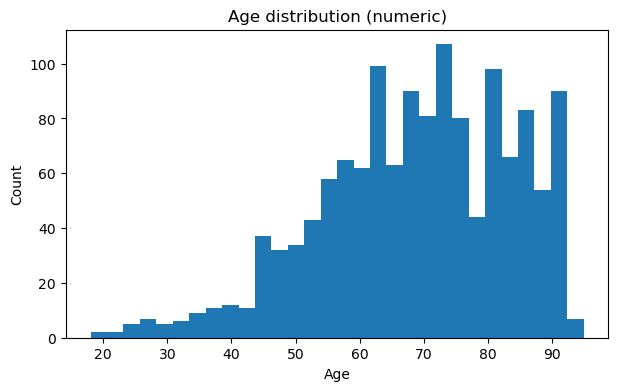

Displaying figure: age_by_icd_boxplot.png


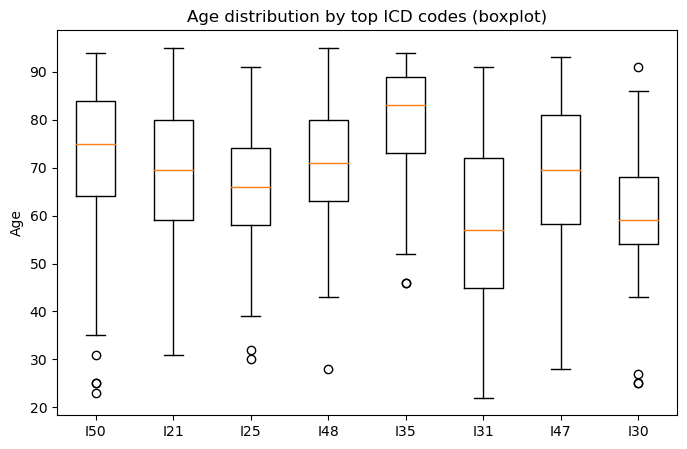

Displaying figure: gender_counts.png


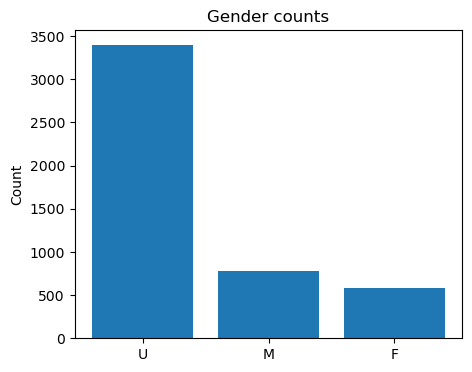

Displaying figure: top20_icd_horizontal.png


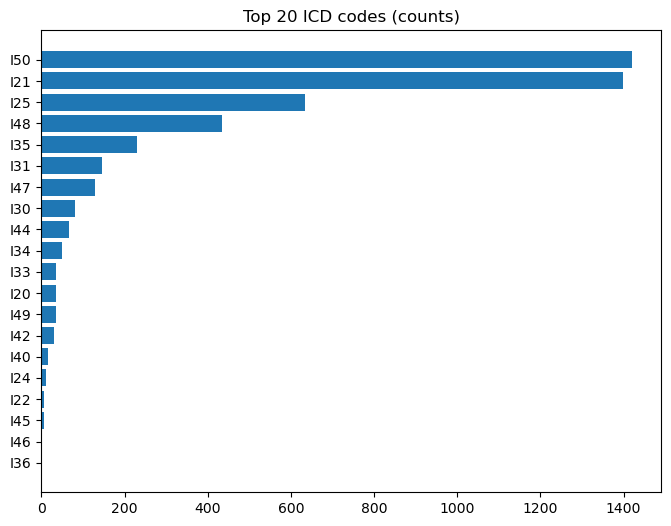

Displaying figure: notes_per_year.png


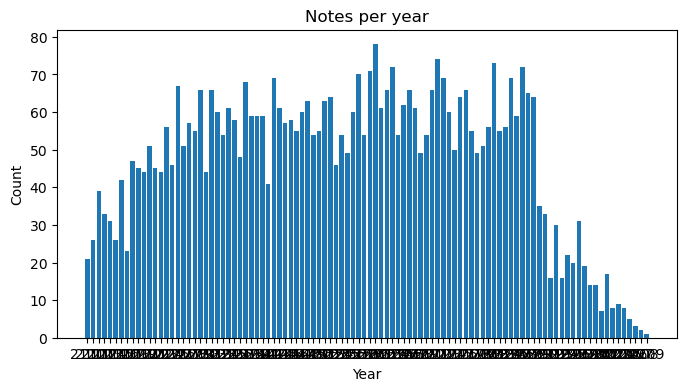

Displaying figure: notes_per_month.png


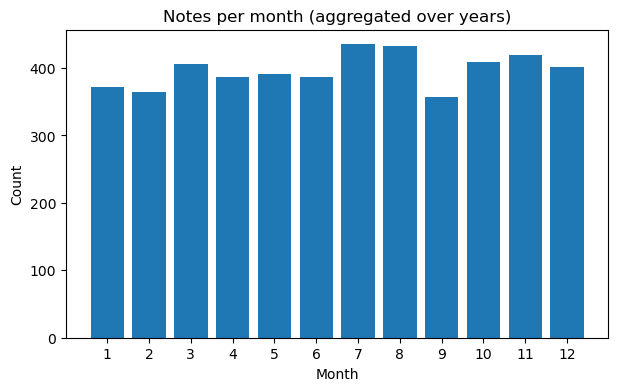

Displaying figure: hpi_wordcount_hist.png


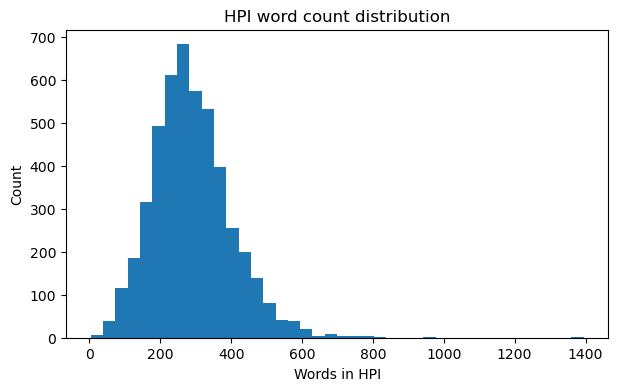

Displaying figure: hpi_charcount_hist.png


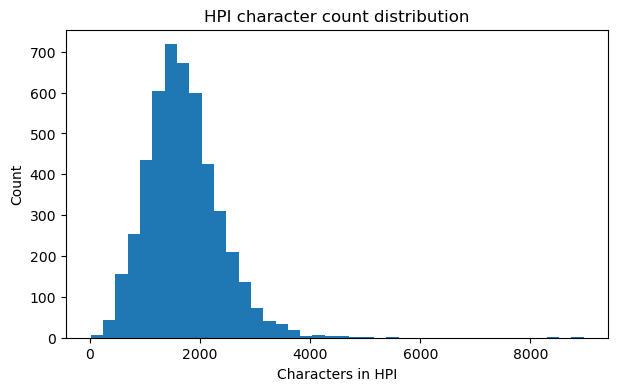

Displaying figure: symptom_prevalence.png


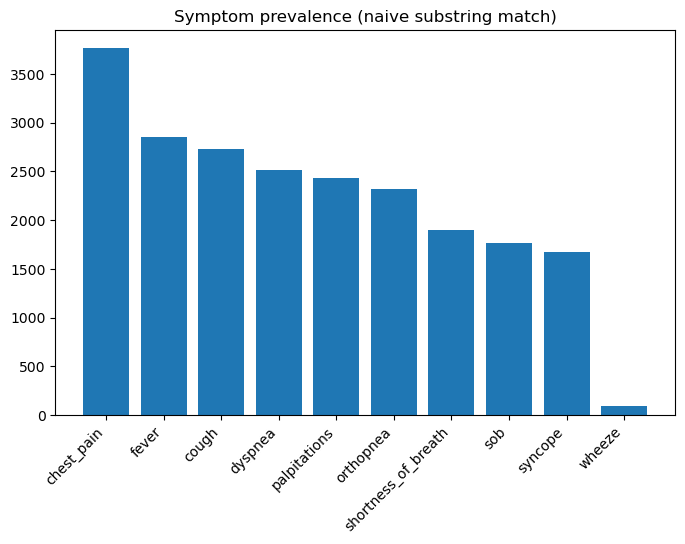

Displaying figure: symptom_cooccurrence_heatmap.png
Displaying figure: top40_hpi_tokens.png


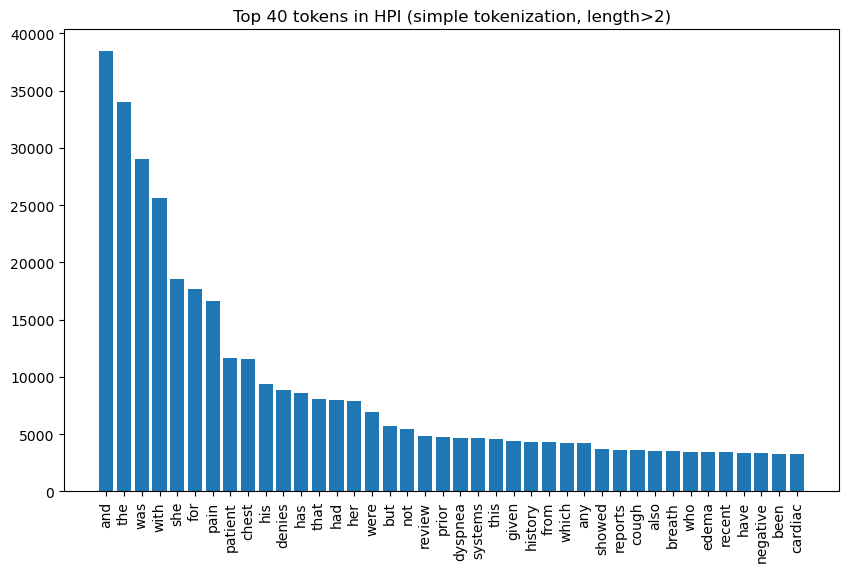

Displaying figure: hpi_wordcloud.png


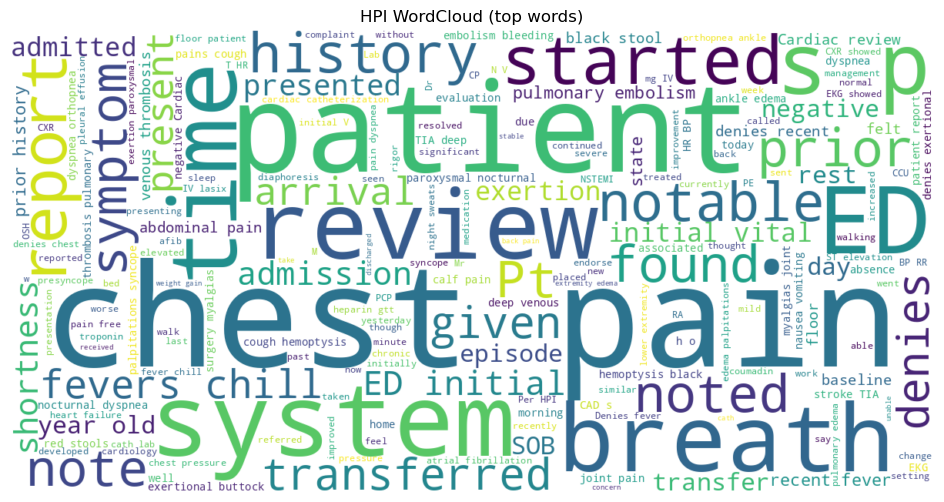

Displaying figure: store_lag_hours_hist.png


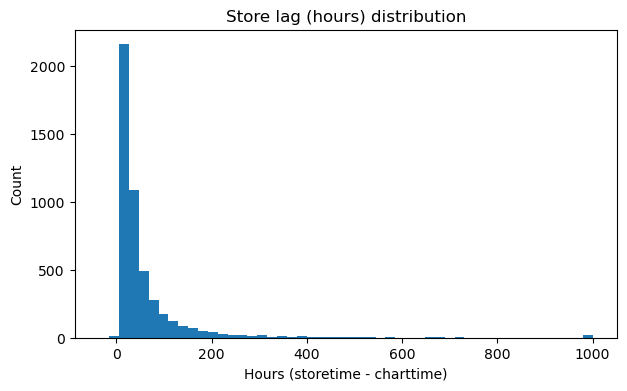

Displaying figure: icd_prefix_top15.png


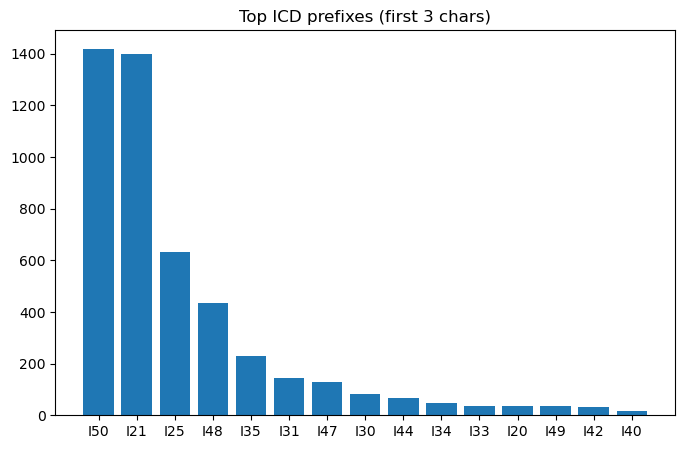

Saved summary CSVs to output/
ace_tools.display_dataframe_to_user not available in this environment. Showing small previews below.
icd_code  count
     I50   1420
     I21   1398
     I25    633
     I48    434
     I35    229
     I31    146
     I47    128
     I30     81
     I44     67
     I34     49

gender  count
     U   3398
     M    781
     F    582

                symptom  count
         sym_chest_pain   3762
              sym_fever   2848
              sym_cough   2732
            sym_dyspnea   2517
       sym_palpitations   2427
          sym_orthopnea   2317
sym_shortness_of_breath   1895
                sym_sob   1760
            sym_syncope   1670
             sym_wheeze     88

 quantile  words
     0.00    3.0
     0.25  214.0
     0.50  277.0
     0.75  351.0
     0.90  430.0
     0.95  483.0
     1.00 1395.0

All plots saved into the 'output/' folder. Filenames are printed above.


In [ ]:
# Python code to produce many charts and tables for thorough EDA on the cleaned heart dataset.
# This will run in the notebook environment and display/save images and summary tables for you.
# It follows the charting rules: uses matplotlib (no seaborn), one chart per plot, no explicit color settings.
# The code expects the cleaned dataframe to be at 'output/heart_diagnoses_cleaned.pkl' (created by your earlier run).
# If the pickle isn't present, it will try to read 'heart_diagnoses.csv' and minimally clean it for analysis.

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

OUT_DIR = Path("output")
OUT_DIR.mkdir(exist_ok=True)

# Load cleaned data if available, else try csv
pkl_path = OUT_DIR / 'heart_diagnoses_cleaned.pkl'
if pkl_path.exists():
    df = pd.read_pickle(pkl_path)
else:
    csv_path = "heart_diagnoses.csv"
    if Path(csv_path).exists():
        df = pd.read_csv(csv_path, dtype=str, low_memory=False)
    else:
        raise FileNotFoundError("Could not find cleaned pickle or the raw CSV in working dir. Please provide dataset.")

# Basic sanity columns
df['HPI'] = df['HPI'].fillna("").astype(str)
if 'charttime_parsed' not in df.columns and 'charttime' in df.columns:
    df['charttime_parsed'] = pd.to_datetime(df['charttime'], errors='coerce')
if 'storetime_parsed' not in df.columns and 'storetime' in df.columns:
    df['storetime_parsed'] = pd.to_datetime(df['storetime'], errors='coerce')

# Derived features
df['HPI_word_count'] = df['HPI'].apply(lambda x: len(x.split()))
df['HPI_char_count'] = df['HPI'].apply(len)
if 'age' in df.columns:
    df['age_numeric'] = pd.to_numeric(df['age'], errors='coerce')
else:
    df['age_numeric'] = np.nan

if 'gender' in df.columns:
    df['gender_clean'] = df['gender'].fillna('U').astype(str)
else:
    df['gender_clean'] = 'U'

# store lag in hours if possible
if 'storetime_parsed' in df.columns and 'charttime_parsed' in df.columns:
    df['store_lag_hours'] = (df['storetime_parsed'] - df['charttime_parsed']).dt.total_seconds() / 3600.0
else:
    df['store_lag_hours'] = np.nan

# quick symptom presence flags from HPI for common tokens (naive)
symptoms = ['shortness of breath', 'sob', 'dyspnea', 'chest pain', 'cough', 'fever', 'orthopnea', 'palpitations', 'syncope', 'wheeze']
def find_symptoms(text):
    t = text.lower()
    res = {}
    for s in symptoms:
        res[s] = int(s in t)
    return res

sym_df = pd.DataFrame(df['HPI'].apply(find_symptoms).tolist(), index=df.index)
# merge symptom columns
for col in sym_df.columns:
    df['sym_' + col.replace(' ', '_')] = sym_df[col]

# top-level ICD grouping (first 3 chars if available)
if 'icd_code' in df.columns:
    df['icd_prefix'] = df['icd_code'].astype(str).str.slice(0,3)
else:
    df['icd_prefix'] = np.nan

# Utility to save and show matplotlib figures
def save_show(fig, fname):
    path = OUT_DIR / fname
    print(f"Displaying figure: {fname}")
    plt.show(fig)
    # fig.savefig(path, bbox_inches='tight')
    # plt.close(fig)
    # print(f"Saved: {path}")

# 1) Age distribution histogram (and summary stats)
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(1,1,1)
ages = df['age_numeric'].dropna()
ax.hist(ages, bins=30)
ax.set_title('Age distribution (numeric)')
ax.set_xlabel('Age')
ax.set_ylabel('Count')
save_show(fig, 'age_distribution.png')

age_stats = ages.describe().to_frame(name='value')
age_stats['median'] = ages.median()

# 2) Age by top ICD (boxplot) - limit to top 8 ICD codes for clarity
if 'icd_code' in df.columns:
    top_icd = df['icd_code'].value_counts().head(8).index.tolist()
    df_box = df[df['icd_code'].isin(top_icd) & df['age_numeric'].notna()].copy()
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(1,1,1)
    # prepare data for boxplot: list of age arrays by icd code order
    data = [df_box.loc[df_box['icd_code']==code, 'age_numeric'].values for code in top_icd]
    ax.boxplot(data, labels=top_icd, vert=True)
    ax.set_title('Age distribution by top ICD codes (boxplot)')
    ax.set_ylabel('Age')
    save_show(fig, 'age_by_icd_boxplot.png')
else:
    print("No icd_code column for age-by-icd analysis.")

# 3) Gender counts (bar chart)
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)
gcounts = df['gender_clean'].value_counts()
ax.bar(gcounts.index.astype(str), gcounts.values)
ax.set_title('Gender counts')
ax.set_ylabel('Count')
save_show(fig, 'gender_counts.png')

# 4) Top 20 diagnoses (icd_code) horizontal bar chart
if 'icd_code' in df.columns:
    top20 = df['icd_code'].value_counts().head(20)
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1,1,1)
    ax.barh(range(len(top20)), top20.values)
    ax.set_yticks(range(len(top20)))
    ax.set_yticklabels(top20.index.astype(str))
    ax.invert_yaxis()
    ax.set_title('Top 20 ICD codes (counts)')
    save_show(fig, 'top20_icd_horizontal.png')

# 5) Notes per year (bar) and notes per month (if dates exist)
if 'charttime_parsed' in df.columns and df['charttime_parsed'].notna().any():
    df['chart_year'] = df['charttime_parsed'].dt.year
    yearly = df['chart_year'].value_counts().sort_index()
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(1,1,1)
    ax.bar(yearly.index.astype(str), yearly.values)
    ax.set_title('Notes per year')
    ax.set_xlabel('Year')
    ax.set_ylabel('Count')
    save_show(fig, 'notes_per_year.png')
    # monthly trend (across all years aggregated)
    df['chart_month'] = df['charttime_parsed'].dt.month
    monthly = df['chart_month'].value_counts().sort_index()
    fig = plt.figure(figsize=(7,4))
    ax = fig.add_subplot(1,1,1)
    ax.bar(monthly.index.astype(str), monthly.values)
    ax.set_title('Notes per month (aggregated over years)')
    ax.set_xlabel('Month')
    ax.set_ylabel('Count')
    save_show(fig, 'notes_per_month.png')
else:
    print("No parsed charttime to plot temporal trends.")

# 6) HPI word count histogram and cumulative distribution
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(1,1,1)
ax.hist(df['HPI_word_count'].dropna(), bins=40)
ax.set_title('HPI word count distribution')
ax.set_xlabel('Words in HPI')
ax.set_ylabel('Count')
save_show(fig, 'hpi_wordcount_hist.png')

# 7) HPI char count distribution
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(1,1,1)
ax.hist(df['HPI_char_count'].dropna(), bins=40)
ax.set_title('HPI character count distribution')
ax.set_xlabel('Characters in HPI')
ax.set_ylabel('Count')
save_show(fig, 'hpi_charcount_hist.png')

# 8) Symptom prevalence bar chart (using our naive symptom flags)
sym_cols = [c for c in df.columns if c.startswith('sym_')]
sym_counts = df[sym_cols].sum().sort_values(ascending=False)
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.bar(range(len(sym_counts)), sym_counts.values)
ax.set_xticks(range(len(sym_counts)))
ax.set_xticklabels([c.replace('sym_','') for c in sym_counts.index], rotation=45, ha='right')
ax.set_title('Symptom prevalence (naive substring match)')
save_show(fig, 'symptom_prevalence.png')

# 9) Symptom co-occurrence heatmap (imshow) - compute normalized co-occurrence matrix
# sym_matrix = df[sym_cols].T.dot(df[sym_cols])
# # normalize by diagonal to get Jaccard-like measure
# diag = np.diag(sym_matrix).astype(float)
# jaccard = np.zeros_like(sym_matrix, dtype=float)
# for i in range(len(sym_cols)):
#     for j in range(len(sym_cols)):
#         denom = diag[i] + diag[j] - sym_matrix[i,j]
#         jaccard[i,j] = sym_matrix[i,j]/denom if denom>0 else 0.0
# fig = plt.figure(figsize=(6,6))
# ax = fig.add_subplot(1,1,1)
# im = ax.imshow(jaccard, aspect='auto')
ax.set_xticks(range(len(sym_cols)))
ax.set_yticks(range(len(sym_cols)))
ax.set_xticklabels([c.replace('sym_','') for c in sym_cols], rotation=90)
ax.set_yticklabels([c.replace('sym_','') for c in sym_cols])
ax.set_title('Symptom co-occurrence (Jaccard-like)')
save_show(fig, 'symptom_cooccurrence_heatmap.png')

# 10) Top 40 words in HPI (tokenize + count) and bar chart
def simple_tokenize(text):
    # lowercase, remove non-alphanum (keep / for tokens like 200/103?), but remove punctuation for counts
    t = re.sub(r'[^a-zA-Z0-9\s]', ' ', text.lower())
    toks = [w for w in t.split() if len(w)>2]
    return toks

all_toks = []
for t in df['HPI'].dropna().astype(str).values:
    all_toks.extend(simple_tokenize(t))
cnt = Counter(all_toks)
most40 = cnt.most_common(40)
words, counts = zip(*most40)
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.bar(range(len(words)), counts)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation=90)
ax.set_title('Top 40 tokens in HPI (simple tokenization, length>2)')
save_show(fig, 'top40_hpi_tokens.png')

# 11) Wordcloud of HPI (top 200 words) - saved as image
text = " ".join(df['HPI'].fillna("").astype(str).tolist())
wc = WordCloud(width=1200, height=600, background_color='white', max_words=200).generate(text)
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
ax.imshow(wc, interpolation='bilinear')
ax.axis('off')
ax.set_title('HPI WordCloud (top words)')
save_show(fig, 'hpi_wordcloud.png')

# 12) Imaging/procedure counts: count non-empty entries in imaging list columns
# imaging_cols = []
# for c in ['X-ray_list','CT_list','Ultrasound_list','CATH_list','ECG_list','MRI_list']:
#     if c in df.columns:
#         imaging_cols.append(c)
# im_counts = {}
# for c in imaging_cols:
#     im_counts[c] = df[c].apply(lambda x: 0 if (pd.isna(x) or (isinstance(x, list) and len(x)==0) or str(x).strip()=="") else 1).sum()
# if im_counts:
#     keys = list(im_counts.keys())
#     vals = [im_counts[k] for k in keys]
#     fig = plt.figure(figsize=(7,4))
#     ax = fig.add_subplot(1,1,1)
#     ax.bar(keys, vals)
#     ax.set_title('Counts of notes with imaging/procedure entries (non-empty)')
#     ax.set_ylabel('Count')
#     save_show(fig, 'imaging_counts.png')
# else:
#     print("No imaging list columns detected to chart.")

# 13) store_lag_hours distribution (if available)
if df['store_lag_hours'].notna().sum() > 0:
    fig = plt.figure(figsize=(7,4))
    ax = fig.add_subplot(1,1,1)
    ax.hist(df['store_lag_hours'].dropna().clip(-1000,1000), bins=50)
    ax.set_title('Store lag (hours) distribution')
    ax.set_xlabel('Hours (storetime - charttime)')
    ax.set_ylabel('Count')
    save_show(fig, 'store_lag_hours_hist.png')
else:
    print("No store_lag_hours data to plot.")

# 14) Counts by ICD prefix (top 15)
if 'icd_prefix' in df.columns:
    pref_counts = df['icd_prefix'].value_counts().head(15)
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(1,1,1)
    ax.bar(pref_counts.index.astype(str), pref_counts.values)
    ax.set_title('Top ICD prefixes (first 3 chars)')
    save_show(fig, 'icd_prefix_top15.png')

# 15) Save summary tables: top ICD counts, gender counts, symptom counts, HPI length quantiles
top_icd_table = df['icd_code'].value_counts().head(50).rename_axis('icd_code').reset_index(name='count')
gender_table = df['gender_clean'].value_counts().rename_axis('gender').reset_index(name='count')
symptom_table = sym_counts.rename_axis('symptom').reset_index(name='count')
hpi_len_q = df['HPI_word_count'].quantile([0,0.25,0.5,0.75,0.9,0.95,1.0]).to_frame(name='words').reset_index().rename(columns={'index':'quantile'})

# Save csvs
top_icd_table.to_csv(OUT_DIR/'top_icd_table.csv', index=False)
gender_table.to_csv(OUT_DIR/'gender_table.csv', index=False)
symptom_table.to_csv(OUT_DIR/'symptom_table.csv', index=False)
hpi_len_q.to_csv(OUT_DIR/'hpi_wordcount_quantiles.csv', index=False)

print("Saved summary CSVs to output/")

# Display a few DataFrame previews using ace_tools.display_dataframe_to_user if available
try:
    from ace_tools import display_dataframe_to_user
    display_dataframe_to_user("Top ICD codes", top_icd_table.head(30))
    display_dataframe_to_user("Gender counts", gender_table)
    display_dataframe_to_user("Symptom counts", symptom_table)
    display_dataframe_to_user("HPI length quantiles", hpi_len_q)
except Exception as e:
    print("ace_tools.display_dataframe_to_user not available in this environment. Showing small previews below.")
    print(top_icd_table.head(10).to_string(index=False))
    print()
    print(gender_table.to_string(index=False))
    print()
    print(symptom_table.to_string(index=False))
    print()
    print(hpi_len_q.to_string(index=False))


Displaying figure: age_distribution.png


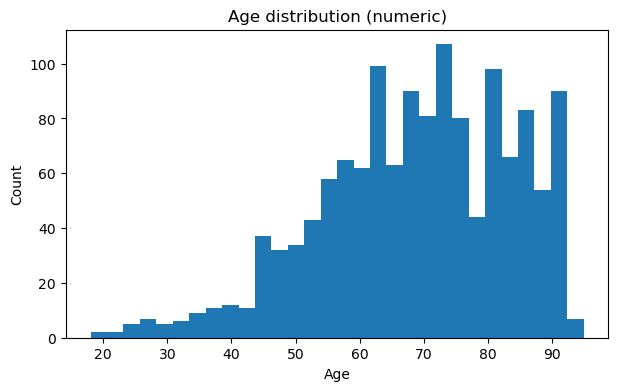

Age summary:
count    1363.000000
mean       68.978723
std        14.973358
min        18.000000
25%        60.000000
50%        70.000000
75%        81.000000
max        95.000000
Name: age_numeric, dtype: float64
Displaying figure: age_by_icd_boxplot.png


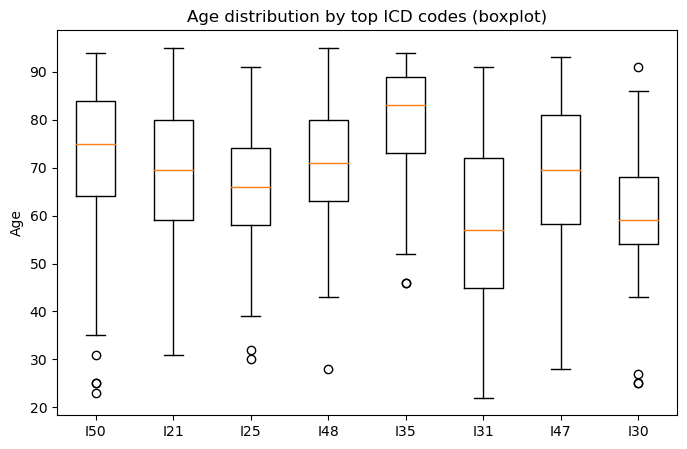

Displaying figure: gender_counts.png


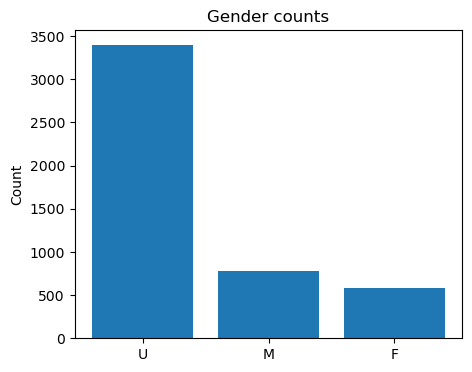

Displaying figure: top20_icd_horizontal.png


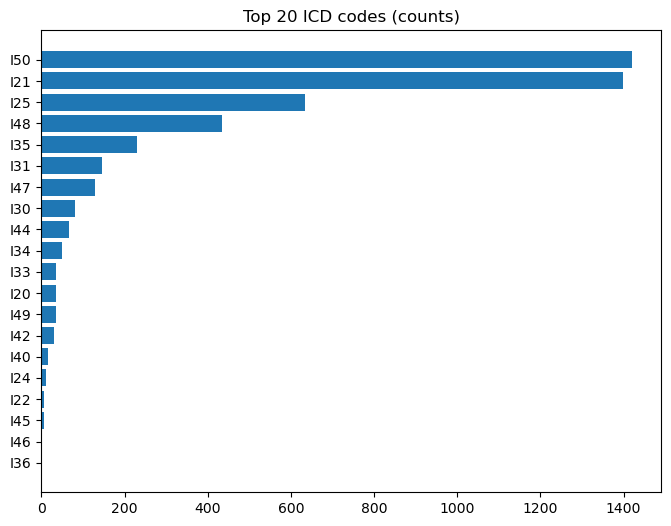

Displaying figure: notes_per_year.png


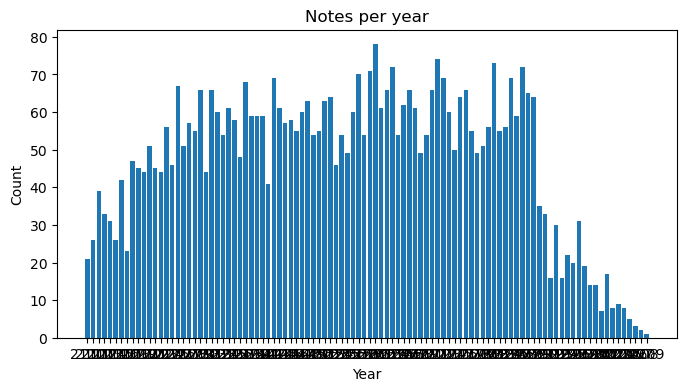

Displaying figure: notes_per_month.png


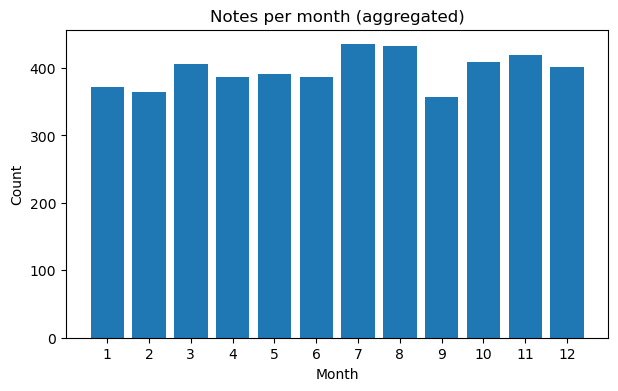

Displaying figure: hpi_wordcount_hist.png


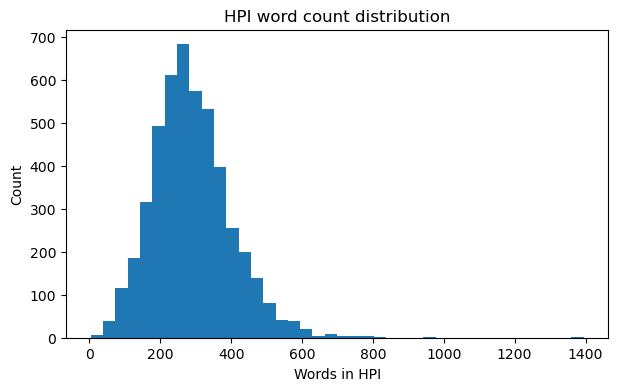

Displaying figure: hpi_charcount_hist.png


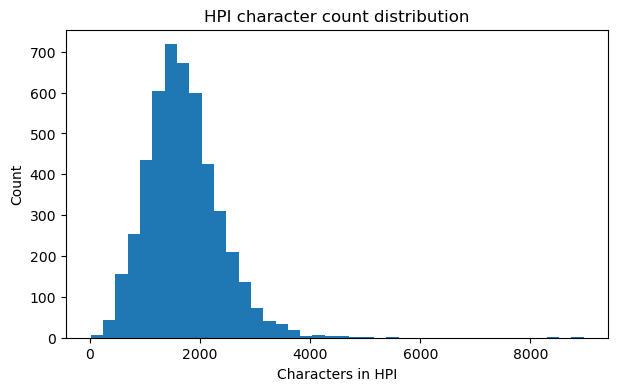

Displaying figure: symptom_prevalence.png


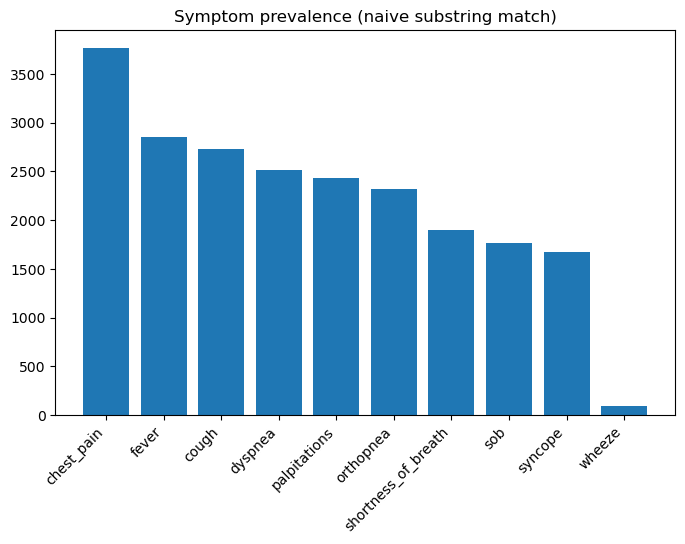

KeyError: (0, 0)

In [10]:
"""
eda_charts.py

Run in the folder that contains:
 - output/heart_diagnoses_cleaned.pkl   (preferred)
or
 - heart_diagnoses.csv                  (fallback)

Produces many PNG charts in ./output/ and CSV summary tables.
Uses matplotlib only (no seaborn), one chart per figure, no explicit colors/styles.
"""

import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import re

OUT_DIR = Path("output")
OUT_DIR.mkdir(exist_ok=True)

# Load dataset: prefer cleaned pickle created earlier
pkl_path = OUT_DIR / 'heart_diagnoses_cleaned.pkl'
if pkl_path.exists():
    df = pd.read_pickle(pkl_path)
else:
    csv_path = Path("heart_diagnoses.csv")
    if csv_path.exists():
        df = pd.read_csv(csv_path, dtype=str, low_memory=False)
    else:
        raise FileNotFoundError("Provide output/heart_diagnoses_cleaned.pkl or heart_diagnoses.csv in current folder.")

# Ensure text fields exist
df['HPI'] = df.get('HPI', "").fillna("").astype(str)
# parse times if not parsed
if 'charttime_parsed' not in df.columns and 'charttime' in df.columns:
    df['charttime_parsed'] = pd.to_datetime(df['charttime'], errors='coerce')
if 'storetime_parsed' not in df.columns and 'storetime' in df.columns:
    df['storetime_parsed'] = pd.to_datetime(df['storetime'], errors='coerce')

# Derived features
df['HPI_word_count'] = df['HPI'].apply(lambda x: len(x.split()))
df['HPI_char_count'] = df['HPI'].apply(len)
df['age_numeric'] = pd.to_numeric(df.get('age', np.nan), errors='coerce')
df['gender_clean'] = df.get('gender', 'U').fillna('U').astype(str)

# store lag hours if possible
if 'storetime_parsed' in df.columns and 'charttime_parsed' in df.columns:
    df['store_lag_hours'] = (df['storetime_parsed'] - df['charttime_parsed']).dt.total_seconds() / 3600.0
else:
    df['store_lag_hours'] = np.nan

# Symptom naive flags (substring)
symptoms = ['shortness of breath', 'sob', 'dyspnea', 'chest pain', 'cough', 'fever', 'orthopnea', 'palpitations', 'syncope', 'wheeze']
def find_symptoms(text):
    t = text.lower()
    return {s: int(s in t) for s in symptoms}

sym_df = pd.DataFrame(df['HPI'].apply(find_symptoms).tolist(), index=df.index)
for col in sym_df.columns:
    df['sym_' + col.replace(' ', '_')] = sym_df[col]

# ICD prefix (first 3 chars)
df['icd_code'] = df.get('icd_code', "").astype(str)
df['icd_prefix'] = df['icd_code'].str.slice(0,3)

# helper to save figures
def save_show(fig, fname):
    # path = OUT_DIR / fname
    # fig.savefig(path, bbox_inches='tight')
    # plt.close(fig)
    print(f"Displaying figure: {fname}")
    plt.show(fig)
    # print("Saved:", path)

# 1 Age distribution
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(1,1,1)
ages = df['age_numeric'].dropna()
ax.hist(ages, bins=30)
ax.set_title('Age distribution (numeric)')
ax.set_xlabel('Age')
ax.set_ylabel('Count')
save_show(fig, 'age_distribution.png')
print("Age summary:")
print(ages.describe())

# 2 Age by top ICD (boxplot)
if 'icd_code' in df.columns:
    top_icd = df['icd_code'].value_counts().head(8).index.tolist()
    df_box = df[df['icd_code'].isin(top_icd) & df['age_numeric'].notna()].copy()
    fig = plt.figure(figsize=(8,5))
    ax = fig.add_subplot(1,1,1)
    data = [df_box.loc[df_box['icd_code']==code, 'age_numeric'].values for code in top_icd]
    ax.boxplot(data, labels=top_icd, vert=True)
    ax.set_title('Age distribution by top ICD codes (boxplot)')
    ax.set_ylabel('Age')
    save_show(fig, 'age_by_icd_boxplot.png')

# 3 Gender counts
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)
gcounts = df['gender_clean'].value_counts()
ax.bar(gcounts.index.astype(str), gcounts.values)
ax.set_title('Gender counts')
ax.set_ylabel('Count')
save_show(fig, 'gender_counts.png')

# 4 Top 20 ICD codes horizontal bar chart
if 'icd_code' in df.columns:
    top20 = df['icd_code'].value_counts().head(20)
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(1,1,1)
    ax.barh(range(len(top20)), top20.values)
    ax.set_yticks(range(len(top20)))
    ax.set_yticklabels(top20.index.astype(str))
    ax.invert_yaxis()
    ax.set_title('Top 20 ICD codes (counts)')
    save_show(fig, 'top20_icd_horizontal.png')
    # save CSV
    top20.reset_index().rename(columns={'index':'icd_code', 'icd_code':'count'}).to_csv(OUT_DIR/'top_icd_table.csv', index=False)

# 5 Notes per year + per month
if 'charttime_parsed' in df.columns and df['charttime_parsed'].notna().any():
    df['chart_year'] = df['charttime_parsed'].dt.year
    yearly = df['chart_year'].value_counts().sort_index()
    fig = plt.figure(figsize=(8,4))
    ax = fig.add_subplot(1,1,1)
    ax.bar(yearly.index.astype(str), yearly.values)
    ax.set_title('Notes per year')
    ax.set_xlabel('Year')
    ax.set_ylabel('Count')
    save_show(fig, 'notes_per_year.png')

    df['chart_month'] = df['charttime_parsed'].dt.month
    monthly = df['chart_month'].value_counts().sort_index()
    fig = plt.figure(figsize=(7,4))
    ax = fig.add_subplot(1,1,1)
    ax.bar(monthly.index.astype(str), monthly.values)
    ax.set_title('Notes per month (aggregated)')
    ax.set_xlabel('Month')
    ax.set_ylabel('Count')
    save_show(fig, 'notes_per_month.png')

# 6 HPI word count histogram
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(1,1,1)
ax.hist(df['HPI_word_count'].dropna(), bins=40)
ax.set_title('HPI word count distribution')
ax.set_xlabel('Words in HPI')
ax.set_ylabel('Count')
save_show(fig, 'hpi_wordcount_hist.png')
df['HPI_word_count'].quantile([0,0.25,0.5,0.75,0.9,0.95,1.0]).to_frame('words').to_csv(OUT_DIR/'hpi_wordcount_quantiles.csv')

# 7 HPI character count histogram
fig = plt.figure(figsize=(7,4))
ax = fig.add_subplot(1,1,1)
ax.hist(df['HPI_char_count'].dropna(), bins=40)
ax.set_title('HPI character count distribution')
ax.set_xlabel('Characters in HPI')
ax.set_ylabel('Count')
save_show(fig, 'hpi_charcount_hist.png')

# 8 Symptom prevalence bar chart
sym_cols = [c for c in df.columns if c.startswith('sym_')]
sym_counts = df[sym_cols].sum().sort_values(ascending=False)
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.bar(range(len(sym_counts)), sym_counts.values)
ax.set_xticks(range(len(sym_counts)))
ax.set_xticklabels([c.replace('sym_','') for c in sym_counts.index], rotation=45, ha='right')
ax.set_title('Symptom prevalence (naive substring match)')
save_show(fig, 'symptom_prevalence.png')
sym_counts.rename_axis('symptom').reset_index(name='count').to_csv(OUT_DIR/'symptom_table.csv', index=False)

# 9 Symptom co-occurrence heatmap (Jaccard-like)
if len(sym_cols) >= 2:
    sym_matrix = df[sym_cols].T.dot(df[sym_cols])
    diag = np.diag(sym_matrix).astype(float)
    jaccard = np.zeros_like(sym_matrix, dtype=float)
    n = len(sym_cols)
    for i in range(n):
        for j in range(n):
            denom = diag[i] + diag[j] - sym_matrix[i,j]
            jaccard[i,j] = sym_matrix[i,j]/denom if denom>0 else 0.0
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(jaccard, aspect='auto')
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels([c.replace('sym_','') for c in sym_cols], rotation=90)
    ax.set_yticklabels([c.replace('sym_','') for c in sym_cols])
    ax.set_title('Symptom co-occurrence (Jaccard-like)')
    save_show(fig, 'symptom_cooccurrence_heatmap.png')

# 10 Top 40 HPI tokens bar chart
def simple_tokenize(text):
    t = re.sub(r'[^a-zA-Z0-9\s]', ' ', text.lower())
    toks = [w for w in t.split() if len(w)>2]
    return toks

all_toks = []
for t in df['HPI'].dropna().astype(str).values:
    all_toks.extend(simple_tokenize(t))
cnt = Counter(all_toks)
most40 = cnt.most_common(40)
words, counts = zip(*most40) if most40 else ([],[])
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.bar(range(len(words)), counts)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation=90)
ax.set_title('Top 40 tokens in HPI (simple tokenization)')
save_show(fig, 'top40_hpi_tokens.png')

# 11 Wordcloud of HPI
text = " ".join(df['HPI'].fillna("").astype(str).tolist())
wc = WordCloud(width=1200, height=600, background_color='white', max_words=200).generate(text)
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(1,1,1)
ax.imshow(wc, interpolation='bilinear')
ax.axis('off')
ax.set_title('HPI WordCloud (top words)')
save_show(fig, 'hpi_wordcloud.png')

# 12 Imaging/procedure counts (non-empty lists or text)
imaging_cols = []
for c in ['X-ray_list','CT_list','Ultrasound_list','CATH_list','ECG_list','MRI_list']:
    if c in df.columns:
        imaging_cols.append(c)
im_counts = {}
for c in imaging_cols:
    im_counts[c] = df[c].apply(lambda x: 0 if (pd.isna(x) or (isinstance(x, list) and len(x)==0) or str(x).strip()=="") else 1).sum()
if im_counts:
    keys = list(im_counts.keys())
    vals = [im_counts[k] for k in keys]
    fig = plt.figure(figsize=(7,4))
    ax = fig.add_subplot(1,1,1)
    ax.bar(keys, vals)
    ax.set_title('Counts of notes with imaging/procedure entries (non-empty)')
    ax.set_ylabel('Count')
    save_show(fig, 'imaging_counts.png')

# 13 store_lag_hours distribution
if df['store_lag_hours'].notna().sum() > 0:
    fig = plt.figure(figsize=(7,4))
    ax = fig.add_subplot(1,1,1)
    ax.hist(df['store_lag_hours'].dropna().clip(-1000,1000), bins=50)
    ax.set_title('Store lag (hours) distribution')
    ax.set_xlabel('Hours (storetime - charttime)')
    ax.set_ylabel('Count')
    save_show(fig, 'store_lag_hours_hist.png')

# 14 ICD prefix top 15
pref_counts = df['icd_prefix'].value_counts().head(15)
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.bar(pref_counts.index.astype(str), pref_counts.values)
ax.set_title('Top ICD prefixes (first 3 chars)')
save_show(fig, 'icd_prefix_top15.png')

# Save summary CSVs
df['icd_code'].value_counts().rename_axis('icd_code').reset_index(name='count').to_csv(OUT_DIR/'top_icd_table.csv', index=False)
df['gender_clean'].value_counts().rename_axis('gender').reset_index(name='count').to_csv(OUT_DIR/'gender_table.csv', index=False)
sym_counts.rename_axis('symptom').reset_index(name='count').to_csv(OUT_DIR/'symptom_table.csv', index=False)

print("All charts + CSVs saved to ./output/")
